In [1]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 87% 129M/149M [00:03<00:00, 47.9MB/s]
100% 149M/149M [00:03<00:00, 49.8MB/s]


In [2]:
!unzip /content/brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

#**Importing the libraries:**

In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

**we will ignore all the warnings if its occurs:**

In [4]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

**The following code collects the file paths and assigns labels based on the folder name from the training folder**

In [5]:
train_data_dir = '/content/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

**We concatenated data paths and labels into one dataframe.**

In [6]:
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

**The resulting training dataframe looks like this:**

In [7]:
train_df

,filepaths,labels
0,/content/Training/pituitary/Tr-pi_0250.jpg,pituitary
1,/content/Training/pituitary/Tr-pi_0906.jpg,pituitary
2,/content/Training/pituitary/Tr-pi_0292.jpg,pituitary
3,/content/Training/pituitary/Tr-pi_0840.jpg,pituitary
4,/content/Training/pituitary/Tr-pi_1064.jpg,pituitary
...,...,...
5707,/content/Training/glioma/Tr-gl_0227.jpg,glioma
5708,/content/Training/glioma/Tr-gl_1087.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0154.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0825.jpg,glioma


**The following code collects the file paths and assigns labels based on the folder name from the testing folder**

In [8]:
# Generate data paths with labels
test_data_dir = '/content/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

**Similarly we apply concatenation of datapaths and labels onto one dataframe for testing dataframe:**

In [9]:
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

**The resulting test dataframe looks like this:**

In [10]:
ts_df

,filepaths,labels
0,/content/Testing/pituitary/Te-pi_0293.jpg,pituitary
1,/content/Testing/pituitary/Te-pi_0247.jpg,pituitary
2,/content/Testing/pituitary/Te-pi_0285.jpg,pituitary
3,/content/Testing/pituitary/Te-pi_0282.jpg,pituitary
4,/content/Testing/pituitary/Te-piTr_0002.jpg,pituitary
...,...,...
1306,/content/Testing/glioma/Te-gl_0225.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0155.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0073.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0083.jpg,glioma


**The following code applies the train and test split onto test dataframe and here we get our valid dataframe. The train_size=0.5 parameter indicates that you want half of the data to be in the validation set, and the other half in the test set.**

In [11]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

**the description of following code is as follows:**

1. we defines the batch size (number of images samples processed together during training) as 16.
2. Then sets the target size for images to 224x224 pixels for resizing.
3. We specifies the number of color channels (3 for RGB images).
4. After channels, we defines the shape of the input images as (224, 224, 3), combining image size and color channels.




In [12]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


**the description of following code is as follows:**
1. We initializes an image data generator for augmenting training images.
2. We initializes an image data generator for augmenting testing or validation images.

In [ ]:
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

**the description of following code is as follows:**
1. We creates a training data generator that reads images and labels from the `train_df` dataframe, resizes images, shuffles data, and provides batches of images and labels in categorical format.


In [ ]:
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

**the description of following code is as follows:**
1. Then similarly we creates a validation data generator that reads images and labels from `valid_df`, resizes, shuffles, and batches them for validation.

In [ ]:
valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

**the description of following code is as follows:**
1. Then creates a test data generator that reads images and labels from `test_df`, resizes them, and batches them without shuffling for testing or evaluation.

In [ ]:
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

**We are visualizing the first 16 images along with its labels from the train dataset.**

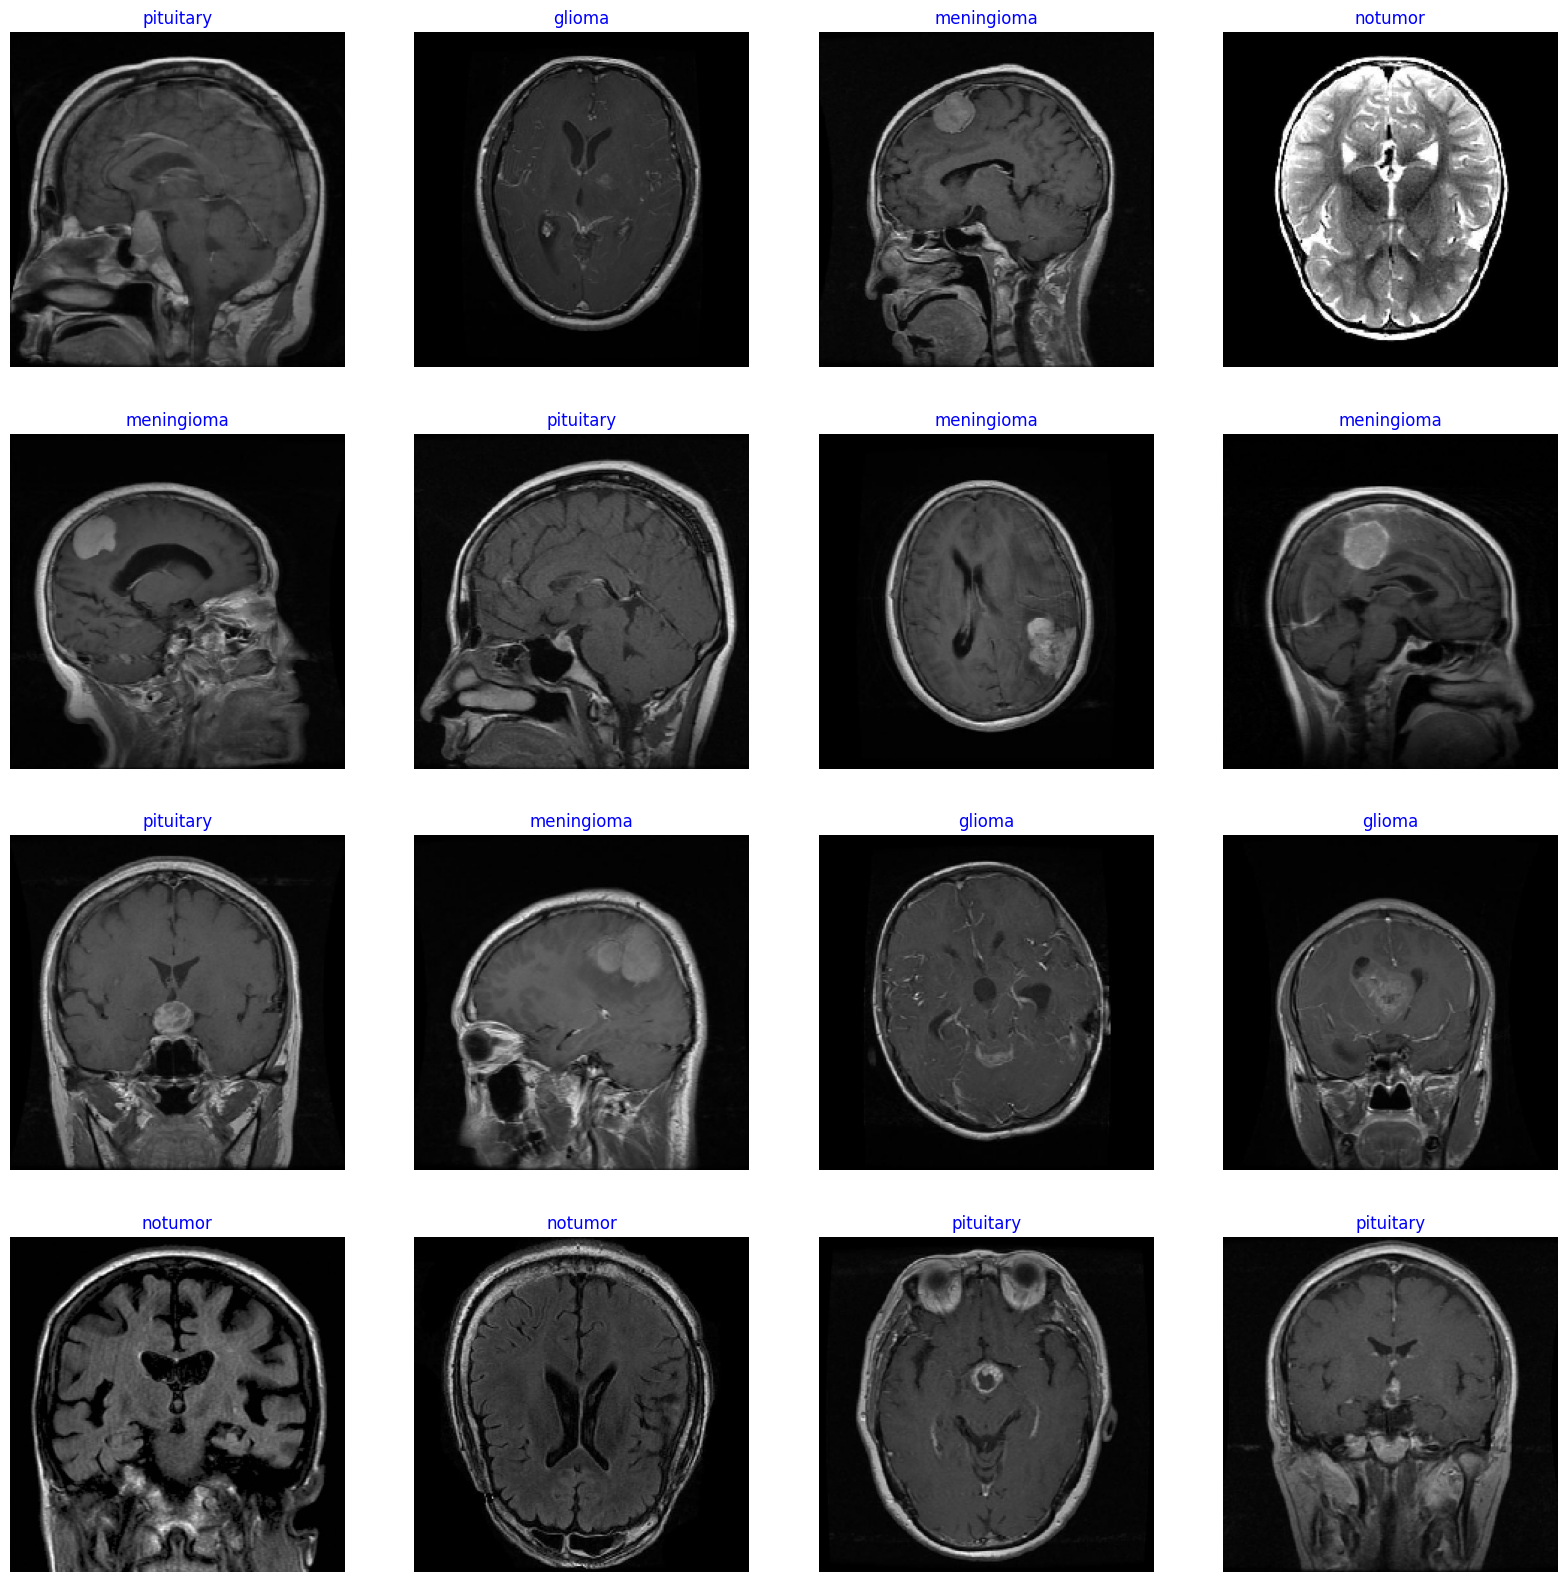

In [13]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

**We are extracting features using pre-trained VGG16 for KNN and SVM model. beacuse these models are machine learning models. it only understands the numerical values and can not process the images. so we are extracting the features of images so these models can understand it.**

In [14]:
vgg = VGG16(include_top=False, input_shape=img_shape, pooling='avg')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
def extract_features(generator, model):
    features = []
    labels = []
    for i, (img, label) in enumerate(generator):
        feature = model.predict(img)
        features.append(feature)
        labels.append(label)
        if i == len(generator) - 1:
            break
    features = np.vstack(features)
    labels = np.argmax(np.vstack(labels), axis=1)
    return features, labels

In [16]:
# extract features for training, validation, and testing datasets
train_features, train_labels = extract_features(train_gen, vgg)
valid_features, valid_labels = extract_features(valid_gen, vgg)
test_features, test_labels = extract_features(test_gen, vgg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

**we applies the label encoding to the labels of train valid and test dataframe to convert it into the numerical format from categorical format.**

In [17]:
# encode labels for KNN and SVM
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
valid_labels_enc = le.transform(valid_labels)
test_labels_enc = le.transform(test_labels)

In [18]:
# train KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features, train_labels_enc)
knn_pred = knn.predict(test_features)
knn_accuracy = accuracy_score(test_labels_enc, knn_pred)

In [19]:
# train SVM model
svm = SVC(kernel='linear', probability=True)
svm.fit(train_features, train_labels_enc)
svm_pred = svm.predict(test_features)
svm_accuracy = accuracy_score(test_labels_enc, svm_pred)

In [20]:
# build CNN model
img_shape = (224, 224, 3)
class_count = 4
cnn_model = Sequential([
    Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=img_shape),
    Conv2D(64, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(128, kernel_size=(3,3), activation="relu"),
    Conv2D(128, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(256, kernel_size=(3,3), activation="relu"),
    Conv2D(256, kernel_size=(3,3), activation="relu"),
    Conv2D(256, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(class_count, activation="softmax")
])

In [21]:
cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=["accuracy"])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 51, 51, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 49, 49, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 47, 47, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 21, 21, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 19, 19, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 17, 17, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,879,428 (56.76 MB)

 Trainable params: 14,879,428 (56.76 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# train CNN model
epochs = 10
history = cnn_model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 123s 263ms/step - accuracy: 0.3714 - loss: 3.6878 - val_accuracy: 0.6687 - val_loss: 0.7874
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 75s 210ms/step - accuracy: 0.7201 - loss: 0.6825 - val_accuracy: 0.7435 - val_loss: 0.6588
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 84s 215ms/step - accuracy: 0.8092 - loss: 0.4951 - val_accuracy: 0.7878 - val_loss: 0.5440
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 76s 212ms/step - accuracy: 0.8654 - loss: 0.3646 - val_accuracy: 0.8076 - val_loss: 0.4784
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 75s 211ms/step - accuracy: 0.8851 - loss: 0.3146 - val_accuracy: 0.8565 - val_loss: 0.3456
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 75s 211ms/step - accuracy: 0.9120 - loss: 0.2417 - val_accuracy: 0.8718 - val_loss: 0.3244
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 76s 212ms/step - accuracy: 0.9359 - loss: 0.1830 - val_accuracy: 0.8901 - val_loss: 0.2870
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 76s 212ms/step - accuracy: 0.9469 - loss: 

In [23]:
# save model to use as feature extractor
cnn_model.save('cnn_model.h5')

In [24]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

In [25]:
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

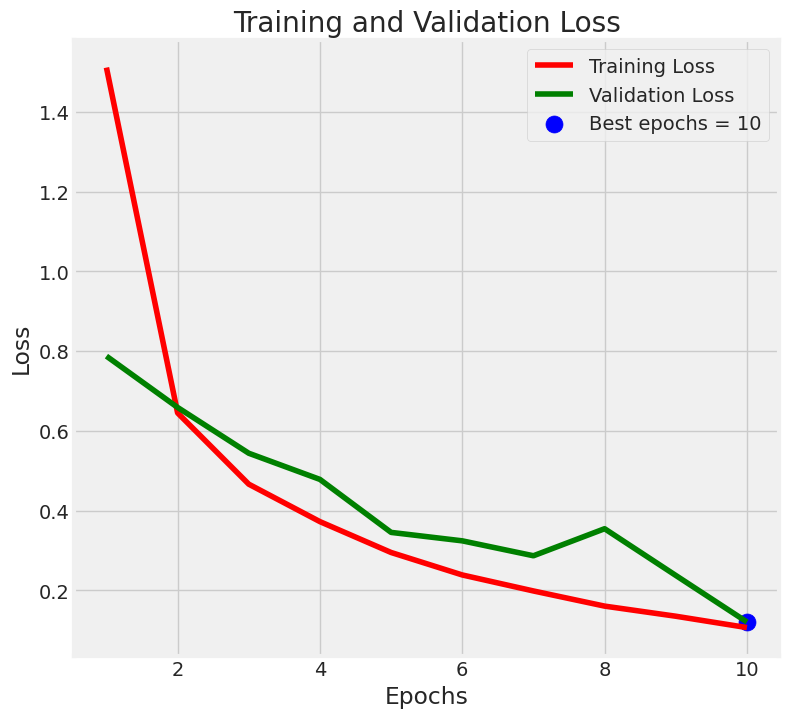

In [26]:
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

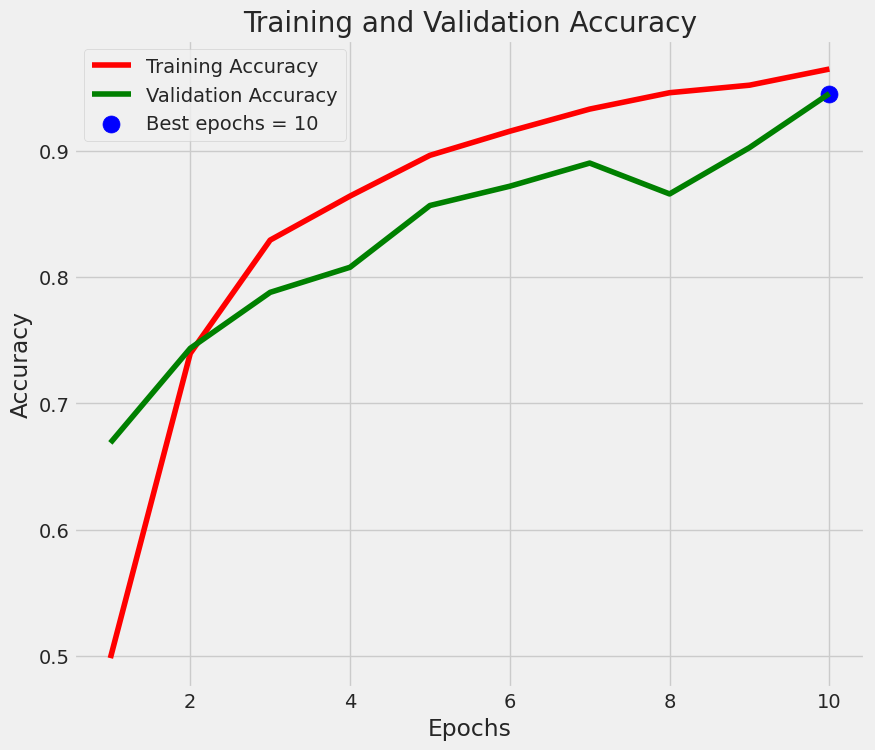

In [28]:
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [29]:
# cnn model evaluation
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_gen)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9755 - loss: 0.0991


In [30]:
# print accuracies
print(f"Accuracy of CNN model: {cnn_accuracy:.2f}")
print(f"Accuracy of KNN model: {knn_accuracy:.2f}")
print(f"Accuracy of SVM model: {svm_accuracy:.2f}")

Accuracy of CNN model: 0.96
Accuracy of KNN model: 0.94
Accuracy of SVM model: 0.95


In [31]:
# plot accuracies for comparison
models = ['CNN', 'KNN', 'SVM']
accuracies = [cnn_accuracy, knn_accuracy, svm_accuracy]

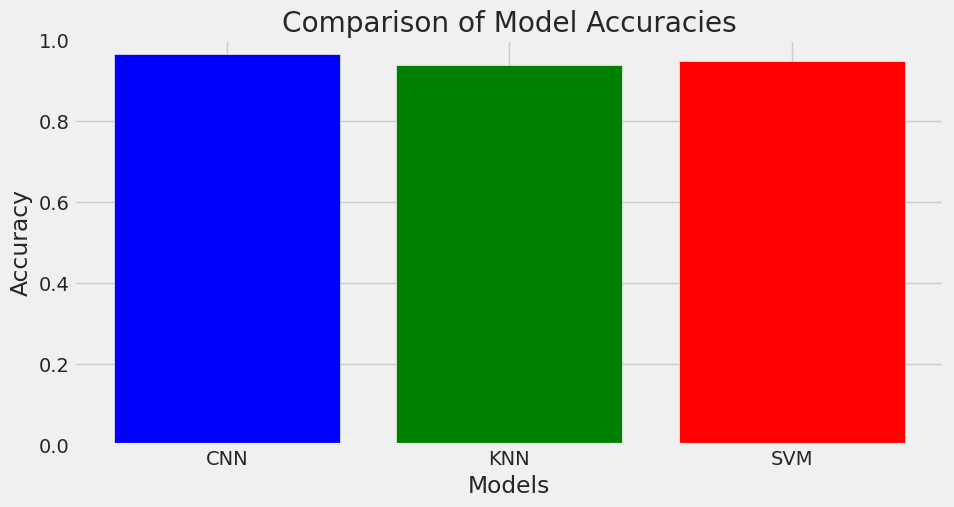

In [32]:
plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
plt.show()